In [1]:
import gym
import numpy as np
import torch
from torch import nn

import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import numpy as np
import gym
from matplotlib import pyplot as plt

from ml_tools.notebook import npi_tqdm

from collections import deque
import matplotlib.animation
from IPython.display import HTML

def animate_agent(env, agent, max_steps = 1000, pred_fn = lambda x: x):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        pred = pred_fn(model(transform_state(obs)))
        action = np.random.choice(np.arange(len(pred.flatten())), p = pred.detach().numpy().flatten())       
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    fig.suptitle(f'Cartpole: {len(frames)} iterations.')
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

In [2]:
class CartPolePolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(4, 8)
        self.l2 = nn.Linear(8, 12)
        self.l3 = nn.Linear(12, 2)
    
    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.softmax(self.l3(x), dim = 1)
        return x

In [3]:
def transform_state(state):
    return torch.from_numpy(state).float().reshape(1, -1)

In [4]:
def play(model, env, fail_penalization = -10., max_dir = 300):
    state = env.reset()
    transitions = []
    done = False
    for t in range(max_dir):
        pred = model(transform_state(state))
        action = np.random.choice(np.arange(len(pred.flatten())), p = pred.detach().numpy().flatten())
        old_state = state
        state, reward, done, info = env.step(action)
        reward = fail_penalization if done else 1.
        transitions.append((old_state, action, reward,))
        if done:
            break
    return transitions

In [5]:
def discount(rewards, gamma):
    k = torch.pow(gamma, torch.arange(len(rewards), dtype = torch.float)) * rewards
    return k / torch.max(torch.abs(k))

In [6]:
def reward_vec(rewards, gamma = 0.999, clip = 1):
    n = len(rewards)
    for i in reversed(range(n - 1)):
        rewards[i] += gamma * rewards[i + 1]
        rewards[i] = min(rewards[i], clip)
        rewards[i] *= np.power(gamma, n - i)
    return rewards

In [7]:
def running_mean(x, N=50):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    ret = (cumsum[N:] - cumsum[:-N]) / float(N)
    
    return list(range(N - 1, len(x))), ret

loss_fn = lambda preds, r: - torch.mean(r * torch.log(preds))

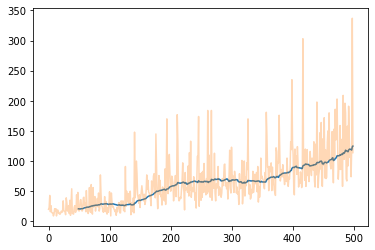

In [8]:
max_dir = 500
env = gym.make('CartPole-v0')
env._max_episode_steps = max_dir

training_iters = 500
gamma = 0.95
learning_rate = 0.005
score = []
model = CartPolePolicyNet()
optimizer = Adam(model.parameters(), lr = learning_rate)
optim_schedule = lr_scheduler.StepLR(optimizer, 500, 0.8)

def plot_fn():
    plt.plot(*running_mean(score))
    plt.plot(score, alpha = 0.3)

for it in npi_tqdm(range(training_iters), plot_fn):
    transitions = play(model, env, -10, max_dir)
    score.append(len(transitions))
    states = torch.Tensor([s for (s,a,t) in transitions])
    actions = torch.tensor([a for (s,a,t) in transitions], dtype = torch.long)
    rewards = torch.tensor([t for (s,a,t) in transitions], dtype = torch.float)
    r = reward_vec(rewards, gamma = gamma)
    
    preds = model(states)
    selected_probs = preds.gather(dim = 1, index = actions.reshape(-1,1))
    loss = loss_fn(selected_probs, r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #optim_schedule.step()

In [9]:
class CartPoleActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(4, 8)
        self.l2 = nn.Linear(8, 12)
        
        self.a1 = nn.Linear(12, 2)
        self.c1 = nn.Linear(12, 8)
        self.c2 = nn.Linear(8, 4)
        self.c3 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        a = F.log_softmax(self.a1(x), dim = 1)
        
        c = F.leaky_relu(self.c1(x.detach()))
        c = F.leaky_relu(self.c2(c))
        c = torch.tanh(self.c3(c))
        return a, c

In [10]:
def play_actor_critic(model, env, fail_penalization = -10., max_dur = 300):
    state = env.reset()
    values, log_probs, rewards = [], [], []
    done = False
    for t in range(max_dur):
        log_policy, value_est = model(transform_state(state))
        action_dist = torch.distributions.Categorical(logits=log_policy)
        action = action_dist.sample()
        log_prob = log_policy.view(-1)[action]
        state, reward, done, info = env.step(int(action))
        reward = fail_penalization if done else 1.
        rewards.append(reward)
        values.append(value_est)
        log_probs.append(log_prob)
        if done:
            break
    return values, log_probs, rewards

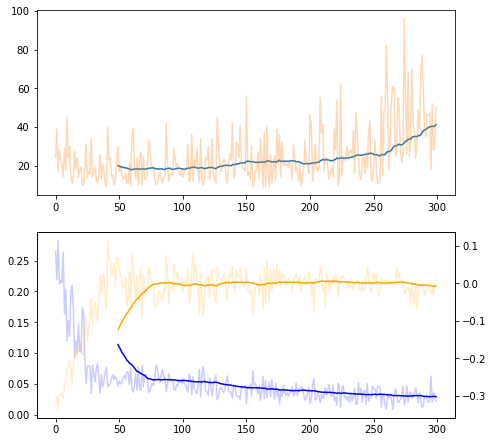

In [11]:
max_dur = 500
env = gym.make('CartPole-v0')
env._max_episode_steps = max_dir

training_iters = 300
gamma = 0.95
learning_rate = 0.005
score = []
model = CartPoleActorCritic()
optimizer = Adam(model.parameters(), lr = learning_rate)
optim_schedule = lr_scheduler.StepLR(optimizer, 750, 0.8)

clc = 0.1
c_loss_fn = nn.MSELoss()

critic_losses = []
actor_losses = []
total_losses = []

def plot_fn():
    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.set_size_inches(7.5, 7.5)

    ax1.plot(*running_mean(score))
    ax1.plot(score, alpha = 0.3)

    ax2_2 = ax2.twinx()
    ax2.plot(*running_mean(critic_losses), c = 'b')
    ax2.plot(critic_losses, alpha = 0.2, c = 'b')
    ax2_2.plot(*running_mean(actor_losses), c = 'orange')
    ax2_2.plot(actor_losses, alpha = 0.2, c = 'orange')


for it in npi_tqdm(range(training_iters), plot_fn):
    values, log_probs, rewards = play_actor_critic(model, env, fail_penalization = -10., max_dur = max_dur)
    rewards = F.normalize(torch.tensor(reward_vec(rewards, gamma = gamma)), dim = 0)
    values = torch.stack(values).reshape(-1)
    log_probs = torch.stack(log_probs).reshape(-1)
    advantage = rewards - values.detach()
    actor_loss = torch.mean(-log_probs * advantage)
    critic_loss = c_loss_fn(rewards, values)
    total_loss = actor_loss + clc * critic_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    optim_schedule.step()
    
    score.append(len(values))
    critic_losses.append(critic_loss.item())
    actor_losses.append(actor_loss.item())
    total_losses.append(total_loss.item())

In [12]:
class NonSharedCartPoleActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.a1 = nn.Linear(4, 8)
        self.a2 = nn.Linear(8, 12)
        self.a3 = nn.Linear(12, 2)
        
        self.c1 = nn.Linear(4, 8)
        self.c2 = nn.Linear(8, 12)
        self.c3 = nn.Linear(12, 1)
    
    def forward(self, x):
        a = F.leaky_relu(self.a1(x))
        a = F.leaky_relu(self.a2(a))
        a = F.log_softmax(self.a3(a), dim = 1)
        
        c = F.leaky_relu(self.c1(x))
        c = F.leaky_relu(self.c2(c))
        c = torch.tanh(self.c3(c))
        return a, c

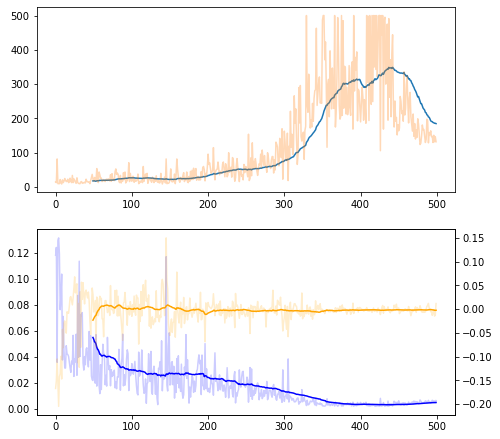

In [13]:
max_dur = 500
env = gym.make('CartPole-v0')
env._max_episode_steps = max_dir

training_iters = 500
gamma = 0.95
learning_rate = 0.005
score = []
model = NonSharedCartPoleActorCritic()
optimizer = Adam(model.parameters(), lr = learning_rate)
optim_schedule = lr_scheduler.StepLR(optimizer, 750, 0.8)

clc = 0.1
c_loss_fn = nn.MSELoss()

critic_losses = []
actor_losses = []
total_losses = []

def plot_fn():
    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.set_size_inches(7.5, 7.5)

    ax1.plot(*running_mean(score))
    ax1.plot(score, alpha = 0.3)

    ax2_2 = ax2.twinx()
    ax2.plot(*running_mean(critic_losses), c = 'b')
    ax2.plot(critic_losses, alpha = 0.2, c = 'b')
    ax2_2.plot(*running_mean(actor_losses), c = 'orange')
    ax2_2.plot(actor_losses, alpha = 0.2, c = 'orange')

for it in npi_tqdm(range(training_iters), plot_fn):
    values, log_probs, rewards = play_actor_critic(model, env, fail_penalization = -10., max_dur = max_dur)
    
    rewards = F.normalize(torch.tensor(reward_vec(rewards, gamma)), dim = 0)
    values = torch.stack(values).reshape(-1)
    log_probs = torch.stack(log_probs).reshape(-1)
    advantage = rewards - values.detach()
    actor_loss = torch.mean(-log_probs * advantage)
    critic_loss = c_loss_fn(rewards, values)
    total_loss = actor_loss + clc * critic_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    optim_schedule.step()
    
    score.append(len(values))
    critic_losses.append(critic_loss.item())
    actor_losses.append(actor_loss.item())
    total_losses.append(total_loss.item())